In [1]:
import tensorflow 

#import keras
import tensorflow.keras as keras
import keras.utils
import sys, os  
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns


from keras.callbacks import ModelCheckpoint
from keras.models import Sequential  
from keras.layers import Dense, Dropout, Activation, Flatten  
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D  
from keras.losses import categorical_crossentropy  
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2  
from keras.utils import np_utils  

from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

keras.backend.clear_session()
df=pd.read_csv('img_pixels.csv')  


In [2]:
plt.show()
 
X_train,train_y,X_test,test_y=[],[],[],[]  
  
for index, row in df.iterrows():  
    val=row['pixels'].split(" ")  
    try:  
        if 'Training' in row['Usage']:  
           X_train.append(np.array(val,'float32'))  
           train_y.append(row['emotion'])  
        elif 'PublicTest' in row['Usage']:  
           X_test.append(np.array(val,'float32'))  
           test_y.append(row['emotion'])  
    except:  
        print(f"error occured at index :{index} and row:{row}")  


In [3]:
num_labels = 5 #changed to 0-4=5  
batch_size = 32
epochs = 50
width, height = 48, 48  
  
  
X_train = np.array(X_train,'float32')  
train_y = np.array(train_y,'float32')  
X_test = np.array(X_test,'float32')  
test_y = np.array(test_y,'float32')  
  
train_y=np_utils.to_categorical(train_y, num_classes=num_labels)  
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)  
  


In [4]:
#cannot produce  
#normalizing data between 0 and 1  
X_train -= np.mean(X_train, axis=0)  
X_train /= np.std(X_train, axis=0)  
  
X_test -= np.mean(X_test, axis=0)  
X_test /= np.std(X_test, axis=0)  
  
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)  
  
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)  
  


In [5]:
##designing the cnn  
#1st convolution layer  
model = keras.models.Sequential() 

depth=1
model.add(Conv2D(64, (3, 3), padding='valid', input_shape=(width, height, depth), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())

# 2nd set Conv layers
model.add(Conv2D(128, (3, 3), padding='valid', input_shape=(width, height, depth), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Set of FC => Relu layers
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Softmax classifier
model.add(Dense(5))
model.add(Activation('softmax'))

# optimizer:

opt=Adam(learning_rate=0.0005)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


classes=[0,1,2,3,4]
classes_labels=["None","Fatigue","Glare","Normal","squint"]

model.summary()

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         2

In [6]:
#tbCallBack = keras.callbacks.TensorBoard(log_dir="C:/Users/Prof. Leah Mutanu/source/repos/pylesson35/pylesson35", histogram_freq=2, write_graph=True, write_images=True)
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, restore_best_weights = True )

lr_scheduler = ReduceLROnPlateau(
	    monitor='val_accuracy',
	    factor=0.5,
	    patience=7,
	    min_lr=1e-7,
	    verbose=1,
	)

mc = ModelCheckpoint('best_model_tt7a.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

callbacks=[es, lr_scheduler, mc]




In [7]:
#Training the model  
history=model.fit(train_datagen.flow(X_train, train_y, batch_size=batch_size),  
          batch_size=batch_size,  
          epochs=epochs,
          verbose=1,  
          callbacks=callbacks,
          validation_data=(X_test, test_y),  
          shuffle=True)  


Epoch 1/50
914/914 [==============================] - 20s 17ms/step - loss: 1.9742 - accuracy: 0.2715 - val_loss: 1.3721 - val_accuracy: 0.4127

Epoch 00001: val_loss improved from inf to 1.37207, saving model to best_model_tt7a.h5
Epoch 2/50
914/914 [==============================] - 15s 16ms/step - loss: 1.4351 - accuracy: 0.3802 - val_loss: 1.2118 - val_accuracy: 0.4953

Epoch 00002: val_loss improved from 1.37207 to 1.21177, saving model to best_model_tt7a.h5
Epoch 3/50
914/914 [==============================] - 15s 16ms/step - loss: 1.2531 - accuracy: 0.4704 - val_loss: 1.1017 - val_accuracy: 0.5651

Epoch 00003: val_loss improved from 1.21177 to 1.10165, saving model to best_model_tt7a.h5
Epoch 4/50
914/914 [==============================] - 15s 16ms/step - loss: 1.1524 - accuracy: 0.5313 - val_loss: 0.9873 - val_accuracy: 0.6021

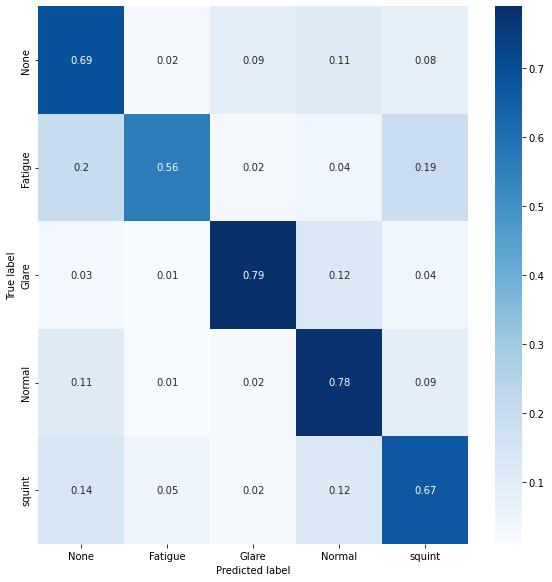

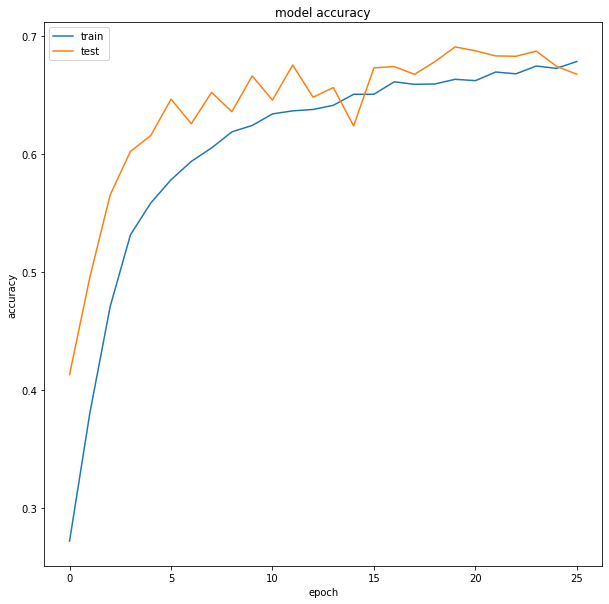

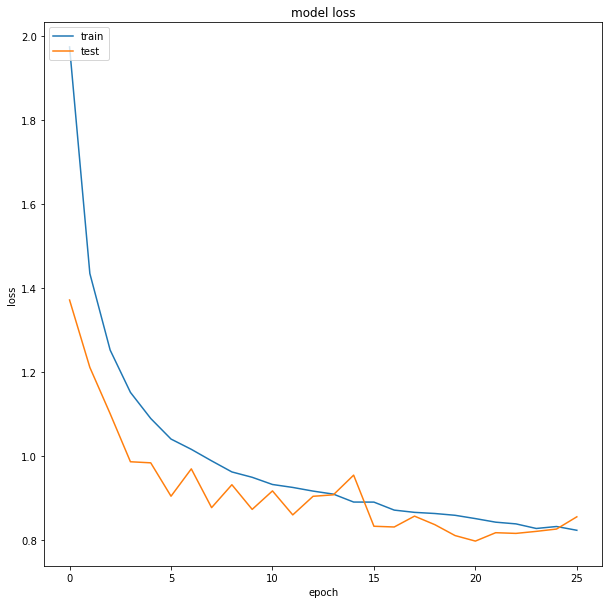

914/914 [==============================] - 5s 6ms/step - loss: 0.7084 - accuracy: 0.7220
Accurracy: 0.7220264673233032


In [8]:
#create confusion matrix
y_true=np.argmax(test_y,axis=1)
y_pred=model.predict(X_test)

con_mat = tensorflow.math.confusion_matrix(labels=y_true, predictions=y_pred.argmax(axis=1)).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes_labels, 
                     columns = classes_labels)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#plot model accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")


#plot model loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

scores = model.evaluate(X_train, train_y, verbose=1, batch_size=batch_size)
print('Accurracy: {}'.format(scores[1]))



In [9]:
#Saving the  model to  use it later on  
fer_json = model.to_json()  
with open("fer_tt7a.json", "w") as json_file:  
    json_file.write(fer_json)  
model.save_weights("fer_tt7a.h5")
